# Earthquake_standardization (guebin)
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA, eigendecomposition]

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx

In [112]:
import time 

In [113]:
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)

In [114]:
from haversine import haversine

##### 1. Data

In [166]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

In [167]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2004" & Year<="2011"').reset_index().iloc[:,1:]

##### 2. $f(x)$ 

In [168]:
f_true = np.array(_df.loc[:,"Magnitude"])

In [169]:
f_true

array([5.5, 5.8, 6.1, ..., 5.5, 6.6, 5.7])

In [170]:
f = (f_true-f_true.mean())/f_true.std()

In [171]:
f@f ## SST 

4517.000000000005

In [172]:
(f-np.mean(f))@(f-np.mean(f)) ## SSE

4517.000000000003

In [173]:
(f*0-np.mean(f))@(f*0-np.mean(f)) ## SSH

3.022296055212013e-29

##### 3. Haversine Fomula 사용한 거리 정의

In [174]:
# def dist(i,j):
#     lat = np.array(_df.Latitude)
#     long = np.array(_df.Longitude)
#     return haversine((lat[i],long[i]),(lat[j],long[j]))

In [175]:
locations = np.array(_df.iloc[:,[1,2]])

In [176]:
dist_matrix = np.zeros((N,N))

In [177]:
for i in range(N):
    for j in range(i,N): 
        dist_matrix[i,j]=haversine(locations[i],locations[j])

In [178]:
dist_matrix = dist_matrix + dist_matrix.T

In [184]:
dist_matrix

array([[    0.        ,  5961.60560635, 10594.64532549, ...,
          283.48765909, 10831.08154775,  5512.17788275],
       [ 5961.60560635,     0.        , 15875.7469962 , ...,
         5819.50260123,  6953.06020638,  9935.96013871],
       [10594.64532549, 15875.7469962 ,     0.        , ...,
        10636.49108416, 12127.14372591,  9114.83672805],
       ...,
       [  283.48765909,  5819.50260123, 10636.49108416, ...,
            0.        , 10553.19437367,  5793.83248054],
       [10831.08154775,  6953.06020638, 12127.14372591, ...,
        10553.19437367,     0.        , 16312.45397939],
       [ 5512.17788275,  9935.96013871,  9114.83672805, ...,
         5793.83248054, 16312.45397939,     0.        ]])

##### 4. Definition of a weighted adjacency matrix $W$

$$W_{u,v}=\begin{cases}{exp(-\frac{[dist(u,v)]^2}{2\theta^2})} & \quad \text{if } dist(u,v) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [126]:
# def weight(i,j,theta=100000,kappa=100000):
#     return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [197]:
theta,kappa = 100000, 100000

In [214]:
W = np.exp( -(dist_matrix/20000)**2)

(array([ 261472.,  982186., 1180314., 1042392., 1435138., 1600586.,
        2109538., 2632908., 3587594., 5571161.]),
 array([0.36765227, 0.43088704, 0.49412181, 0.55735659, 0.62059136,
        0.68382613, 0.74706091, 0.81029568, 0.87353045, 0.93676523,
        1.        ]),
 <BarContainer object of 10 artists>)

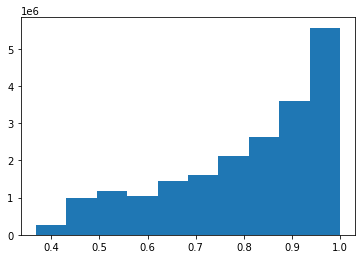

In [216]:
plt.hist(W.reshape(-1))

##### 5. The weight edge function with temporal edge $(v_t,v_{t+1})$

$$W_{u_r,v_s}=\begin{cases} {W_{u,v}} & \quad \text{ if }  u,v \in V_t  \\ W_{u,v} \odot \beta  & \quad \text{if }u=v \text{ and } r=s-1 \\ 0 & \quad \text{otherwise} \end{cases}$$

In [217]:
# def beta(i,j,b):
#     if _df.Year[i] == _df.Year[j]:
#         return 1
#     elif abs(int(_df.Year[i]) - int(_df.Year[j])) == 1:
#         return b
#     else:
#         return 0

In [218]:
_df.groupby("Year").aggregate(len)

,Date,Latitude,Longitude,Magnitude
Year,,,,
2004,571,571,571,571
2005,533,533,533,533
2006,508,508,508,508
2007,608,608,608,608
2008,508,508,508,508
2009,517,517,517,517
2010,560,560,560,560
2011,712,712,712,712


In [219]:
Nlst = _df.groupby("Year").aggregate(len).Date.tolist()
Nlst = np.cumsum(Nlst)
Nlst

array([ 571, 1104, 1612, 2220, 2728, 3245, 3805, 4517])

In [220]:
_beta =np.zeros((N,N))
_beta

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [163]:
a=0
_beta =np.zeros((N,N))
for i in range(len(Nlst)):
    b=Nlst[i] 
    _beta[a:b,a:b]= np.ones(b-a,b-a)
    a=Nlst[i]

In [156]:
a=0
_beta =np.zeros((N,N))
for i in range(len(Nlst)):
    b=Nlst[i] 
    _beta[a:b,a:b]= np.ones(b-a)
    a=Nlst[i]

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [ ]:
a=0
_beta =np.zeros((N,N))
for i in range(len(Nlst)):
    b=Nlst[i] 
    _beta[a:b,a:b]= np.ones(b-a)*beta 
    a=Nlst[i]

In [121]:
_beta = np.array([[beta(i,j,1) for i in  range(len(_df))] for j in range(len(_df))])

KeyboardInterrupt: 

In [13]:
_W = W @ _beta

##### 6. Definition of Graph Laplacian matrix
- $L = D - W$

In [14]:
D = np.diag(_W.sum(axis=1))

In [15]:
L = D - _W

##### 7. Eigendecomposition
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [16]:
λ, Ψ = np.linalg.eig(L)

In [17]:
Λ = np.diag(λ)

##### 8. Principal components Analysis

- $comp_k = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, n$
- $p = \sum_{1}^{n} comp_{1}^{2},\sum_{1}^{n} comp_{2}^{2},…,\sum_{1}^{n} comp_{n}^{2}$
- $p = \frac{p}{\sum(p)}$

In [415]:
def p(i):
    return sum((f @ np.outer( Ψ[:,i], Ψ[:,i]))**2)

In [416]:
array_1 = np.array([p(i) for i in range(1,len(_df))])
varprop = array_1/array_1.sum()
_index = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop}).sort_values('varprop',ascending=False)
_indexlst = _index.iloc[:25,0].tolist()

In [494]:
array_1

array([0.52276772+0.j, 0.61006958+0.j, 1.06829524+0.j, ...,
       0.01180676+0.j, 0.2273058 +0.j, 0.22628734+0.j])

In [417]:
_df["comp1"] = f @ np.outer( Ψ[:,0], Ψ[:,0])
_df["comp2"] = f @ np.outer( Ψ[:,_indexlst[0]], Ψ[:,_indexlst[0]])
_df["comp3"] = f @ np.outer( Ψ[:,_indexlst[1]], Ψ[:,_indexlst[1]])
_df["comp4"] = f @ np.outer( Ψ[:,_indexlst[2]], Ψ[:,_indexlst[2]])
_df["comp5"] = f @ np.outer( Ψ[:,_indexlst[3]], Ψ[:,_indexlst[3]])
_df["comp6"] = f @ np.outer( Ψ[:,_indexlst[4]], Ψ[:,_indexlst[4]])
_df["comp7"] = f @ np.outer( Ψ[:,_indexlst[5]], Ψ[:,_indexlst[5]])

##### **2004**, $n=571$

In [418]:
_G1 = nx.Graph(_W[:len(_df.query('Year<="2004"')),:len(_df.query('Year<="2004"'))]-np.identity(len(_df.query('Year=="2004"'))))
_pos1 = nx.spring_layout(_G1,iterations=20)
m_pos1 = list(zip(_df.query('Year=="2004"').Longitude,_df.query('Year=="2004"').Latitude))

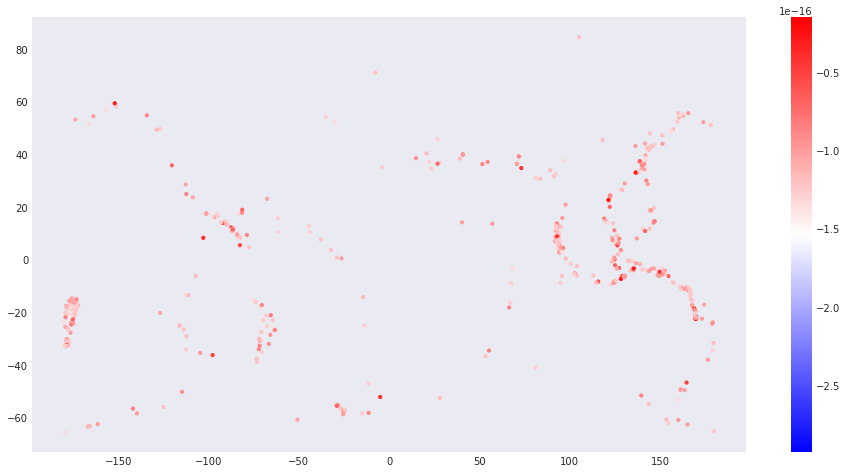

In [419]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

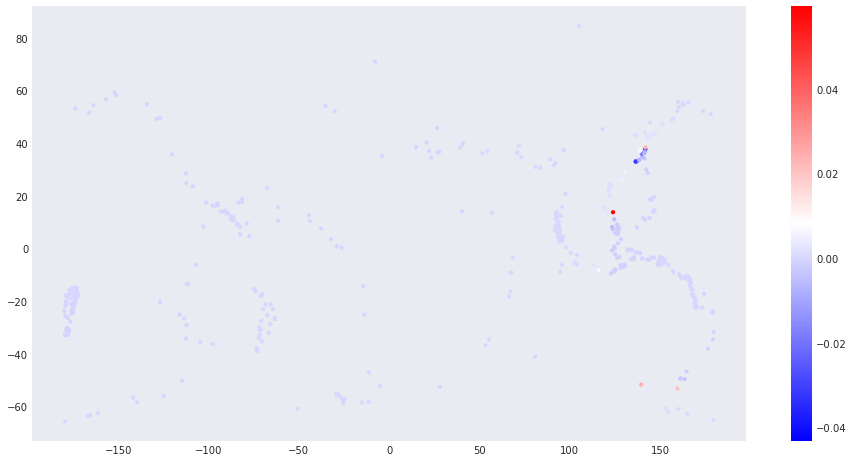

In [420]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

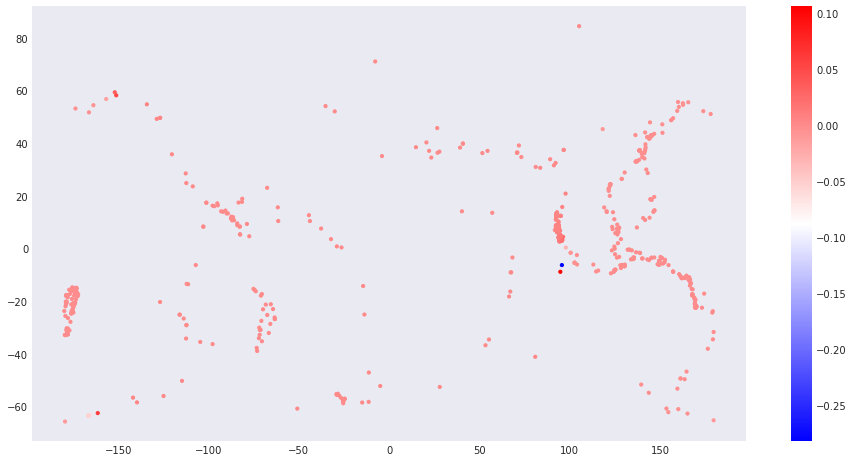

In [421]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

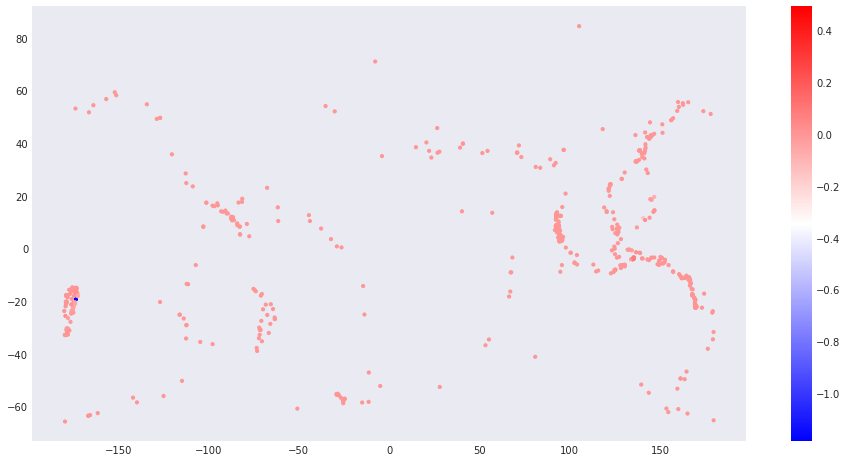

In [422]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

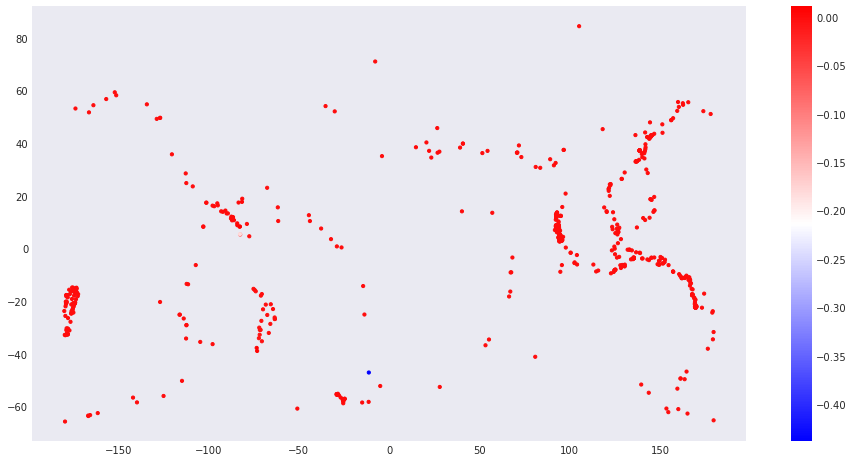

In [423]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

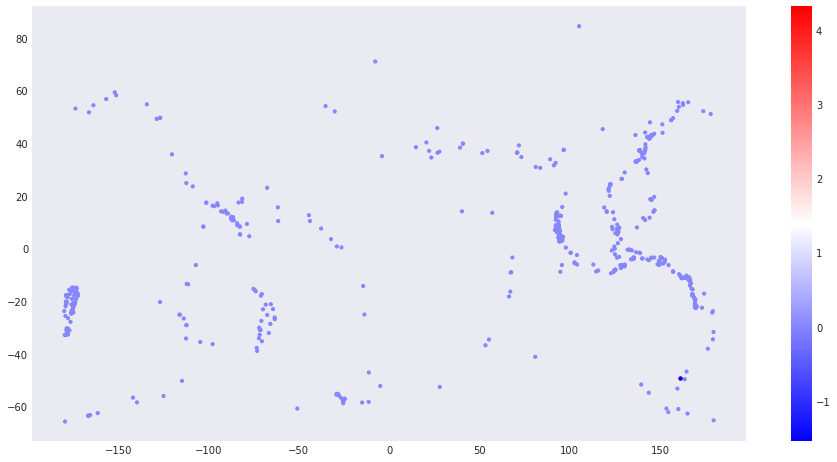

In [424]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

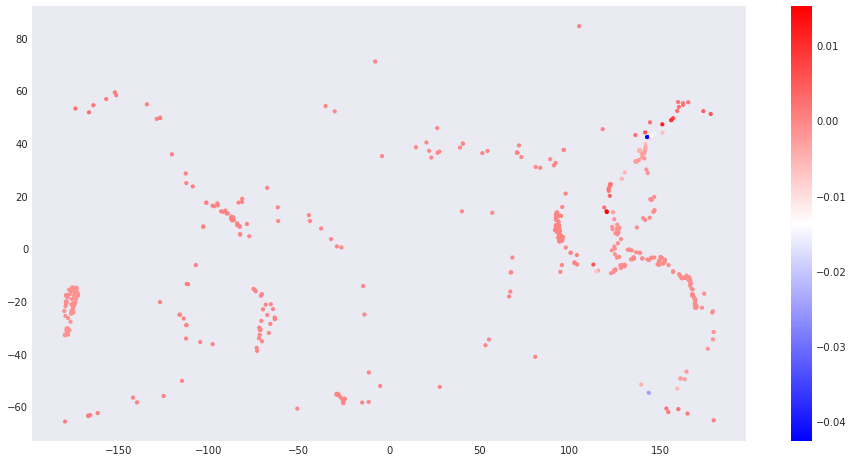

In [425]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2005**, $n=533$

In [426]:
_G2 = nx.Graph(_W[len(_df.query('Year<="2004"')):len(_df.query('Year<="2005"')),len(_df.query('Year<="2004"')):len(_df.query('Year<="2005"'))]-np.identity(len(_df.query('Year=="2005"'))))
_pos2 = nx.spring_layout(_G2,iterations=20)
m_pos2 = list(zip(_df.query('Year=="2005"').Longitude,_df.query('Year=="2005"').Latitude))

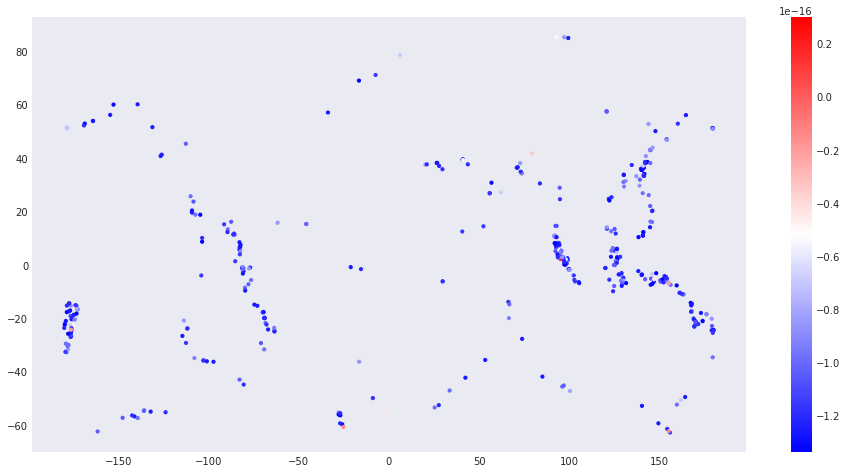

In [427]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

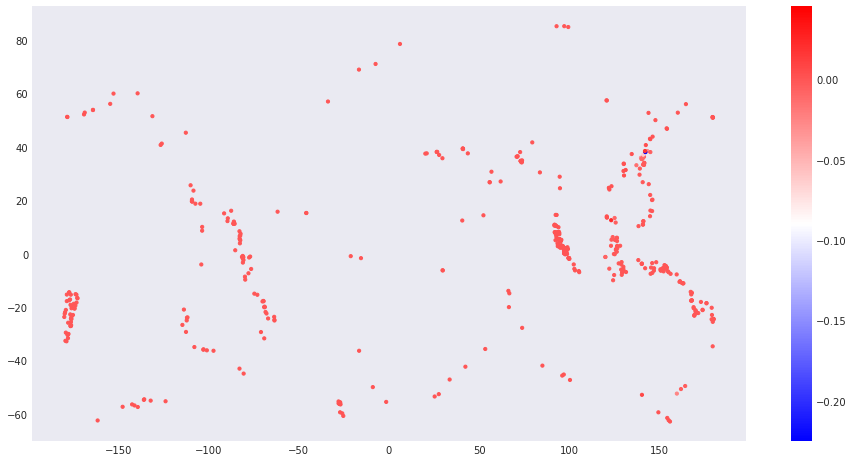

In [428]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

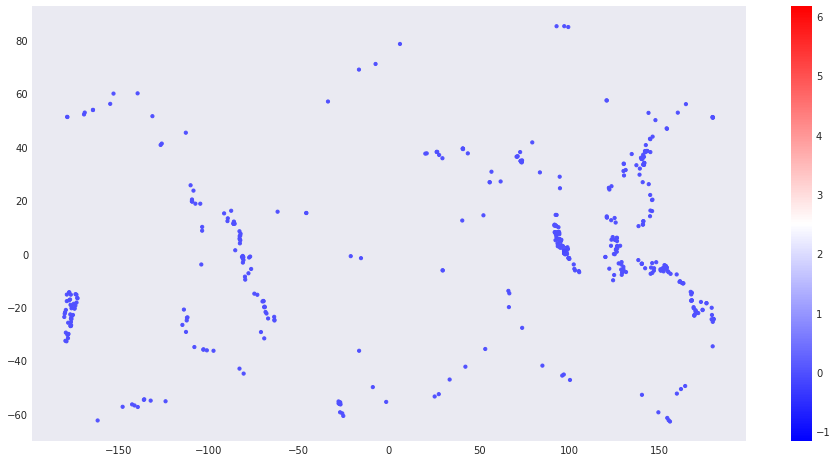

In [429]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

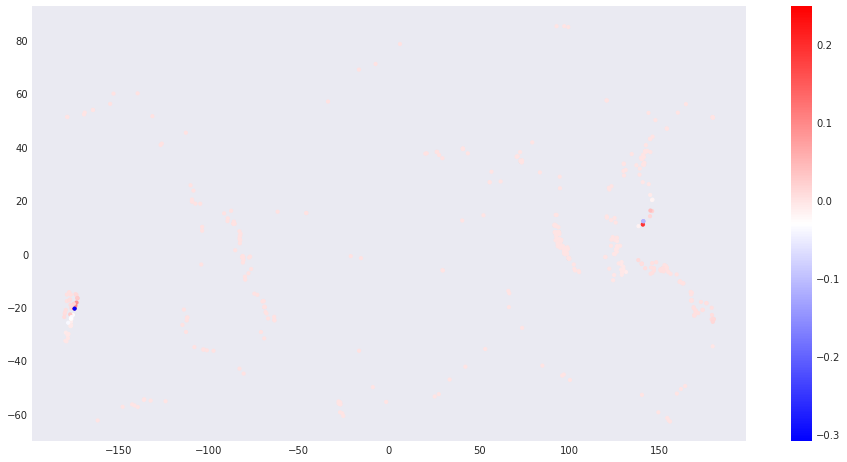

In [430]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

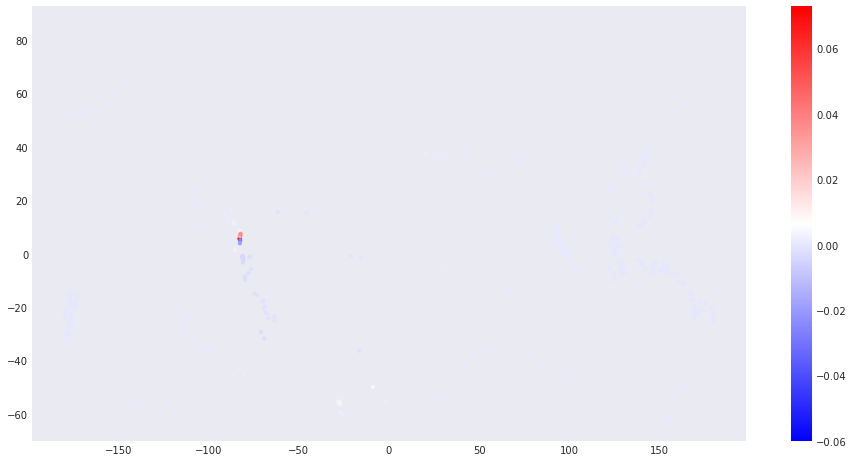

In [431]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

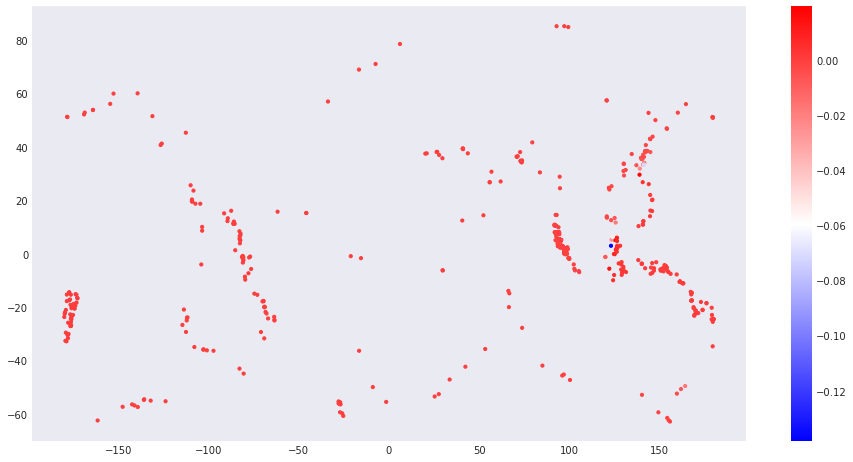

In [432]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

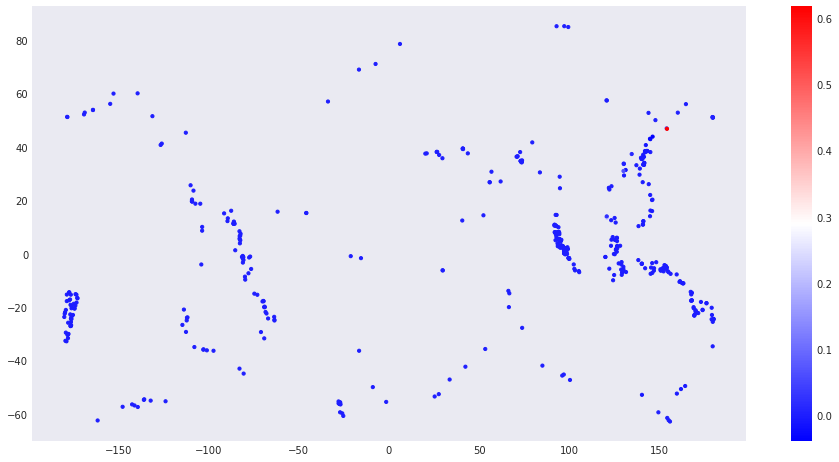

In [433]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2006**, $n=512$

In [434]:
_G3 = nx.Graph(_W[len(_df.query('Year<="2005"')):len(_df.query('Year<="2006"')),len(_df.query('Year<="2005"')):len(_df.query('Year<="2006"'))]-np.identity(len(_df.query('Year=="2006"'))))
_pos3 = nx.spring_layout(_G3,iterations=20)
m_pos3 = list(zip(_df.query('Year=="2006"').Longitude,_df.query('Year=="2006"').Latitude))

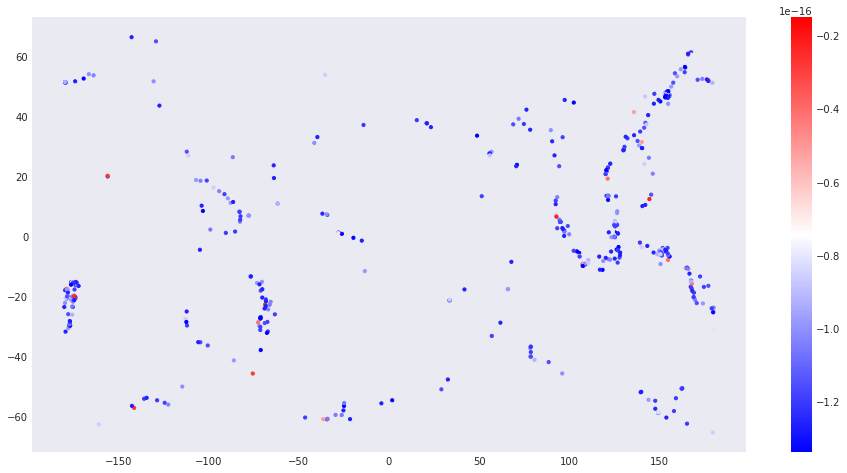

In [435]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

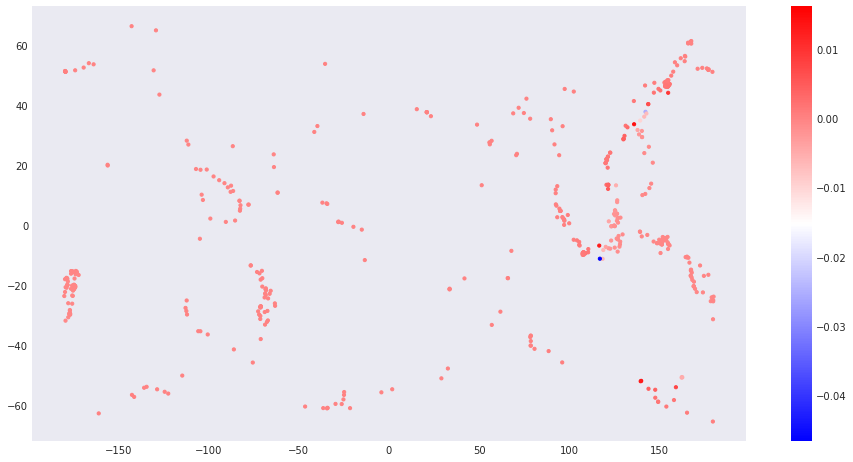

In [436]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

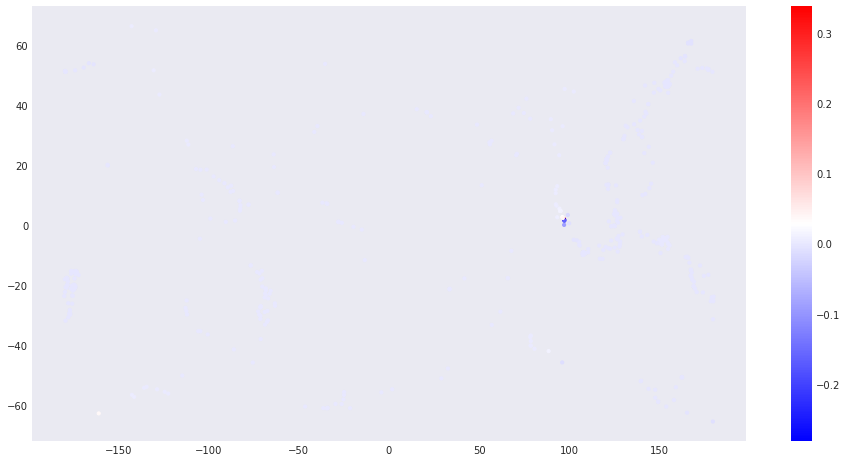

In [437]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

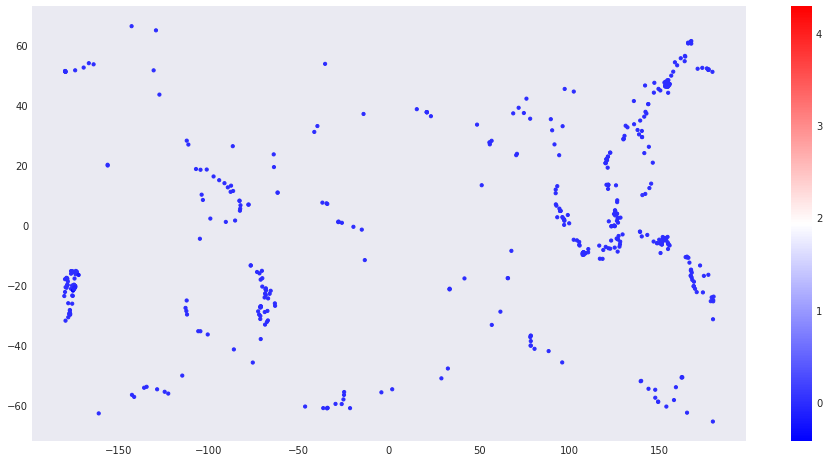

In [438]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

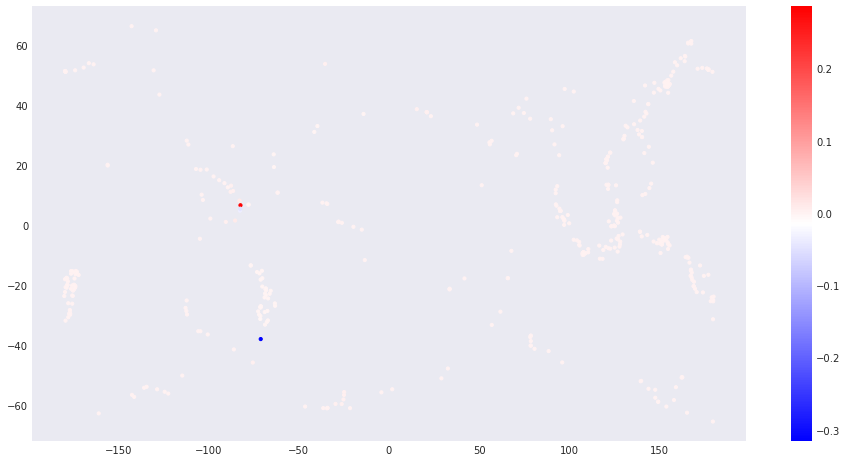

In [439]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

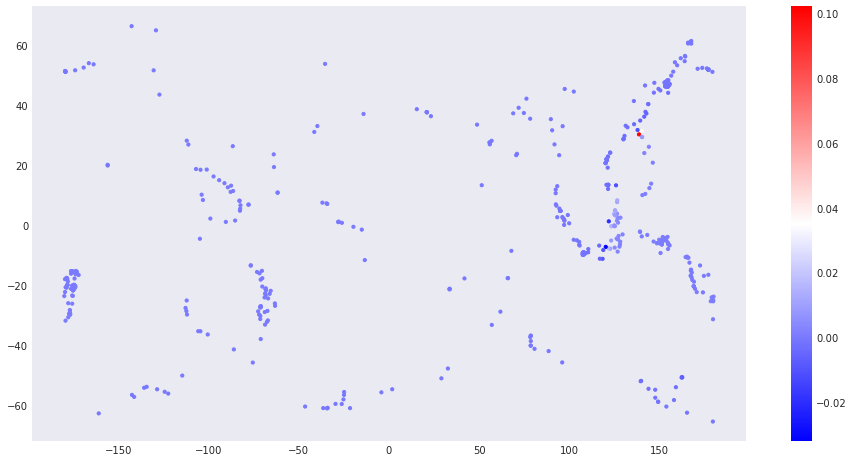

In [440]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

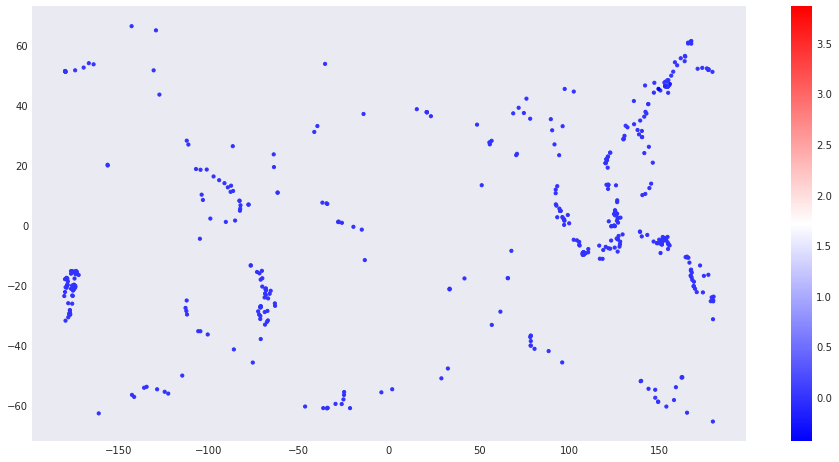

In [441]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2007**, $n=608$

In [442]:
_G4 = nx.Graph(_W[len(_df.query('Year<="2006"')):len(_df.query('Year<="2007"')),len(_df.query('Year<="2006"')):len(_df.query('Year<="2007"'))]-np.identity(len(_df.query('Year=="2007"'))))
_pos4 = nx.spring_layout(_G4,iterations=20)
m_pos4 = list(zip(_df.query('Year=="2007"').Longitude,_df.query('Year=="2007"').Latitude))

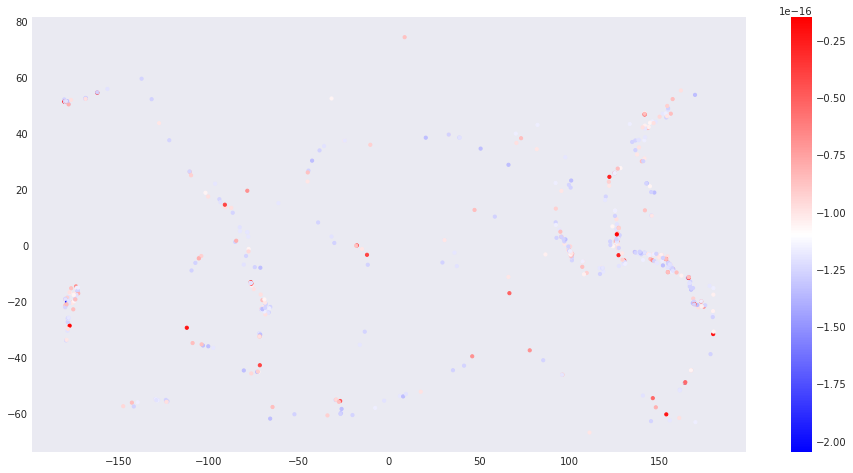

In [443]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

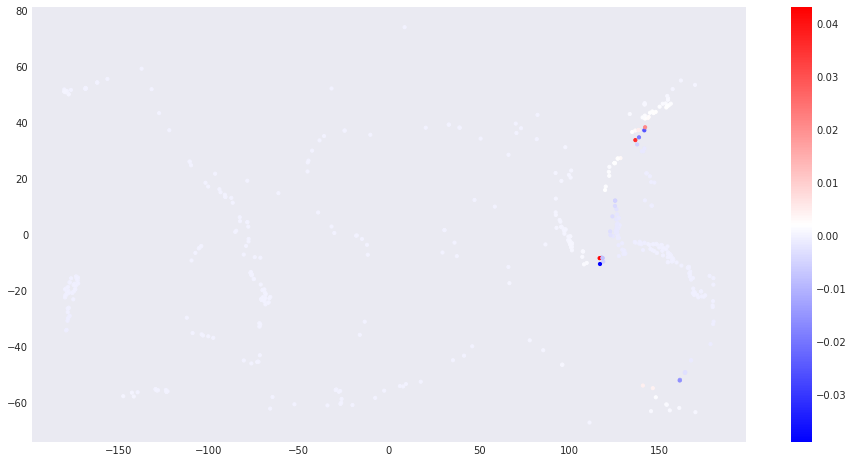

In [444]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

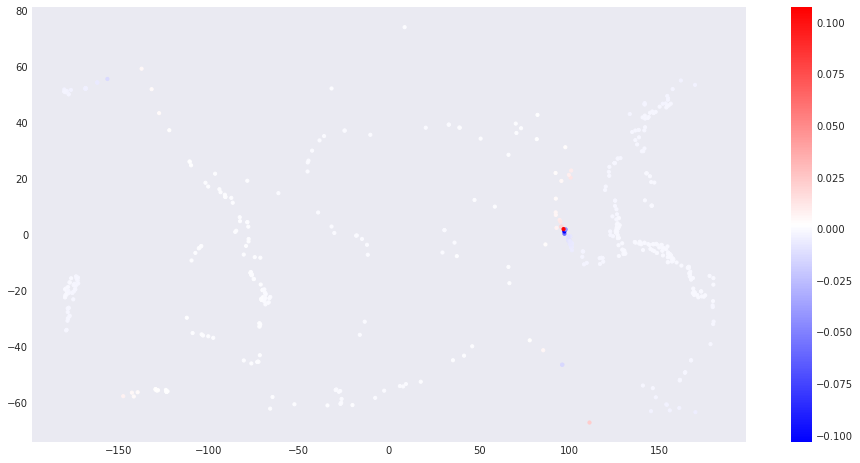

In [445]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp3,node_size =10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

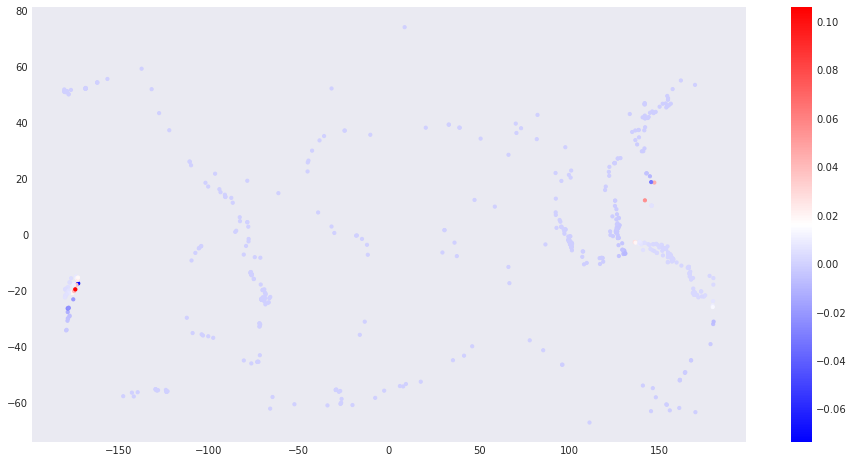

In [446]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

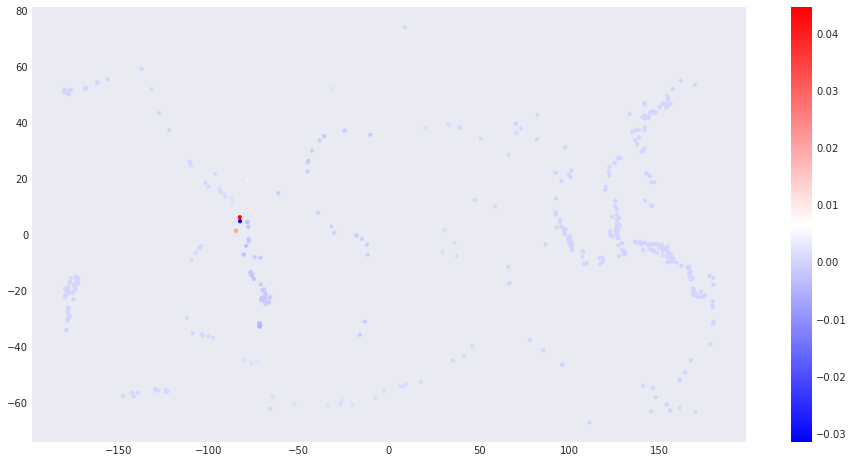

In [447]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

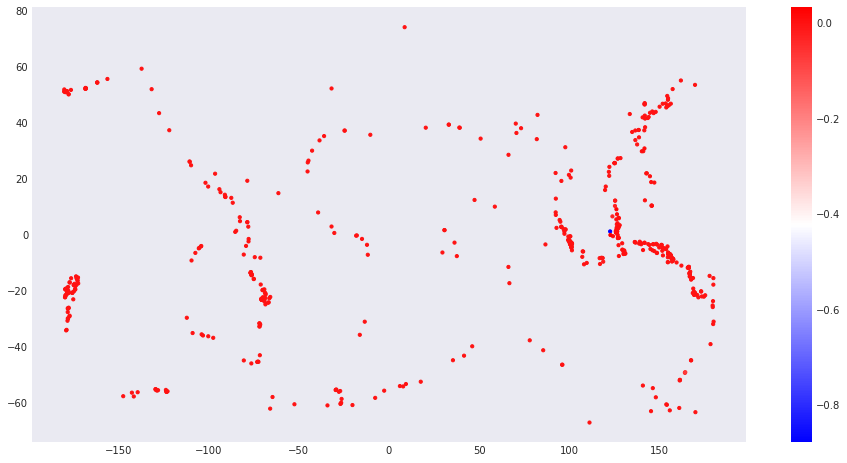

In [448]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

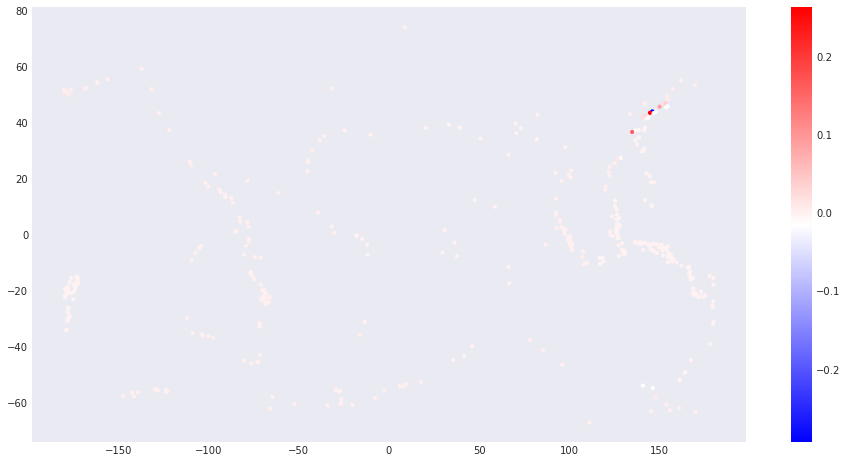

In [449]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2008**, $n=508$

In [450]:
_G5 = nx.Graph(_W[len(_df.query('Year<="2007"')):len(_df.query('Year<="2008"')),len(_df.query('Year<="2007"')):len(_df.query('Year<="2008"'))]-np.identity(len(_df.query('Year=="2008"'))))
_pos5 = nx.spring_layout(_G5,iterations=20)
m_pos5 = list(zip(_df.query('Year=="2008"').Longitude,_df.query('Year=="2008"').Latitude))

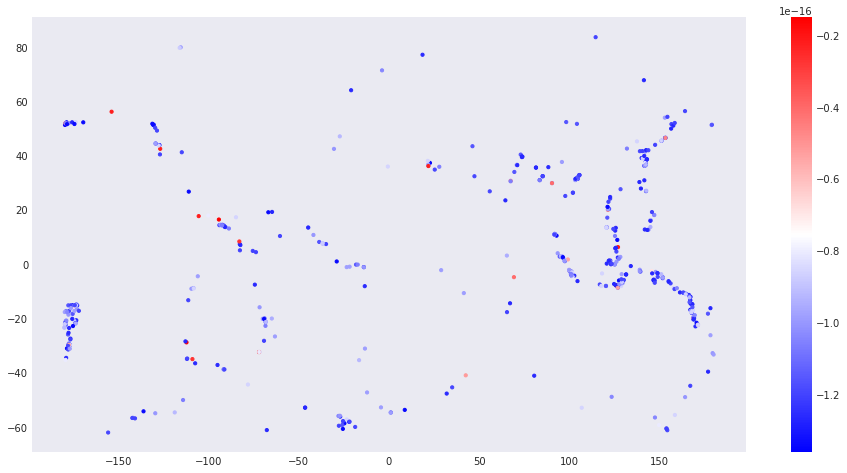

In [451]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

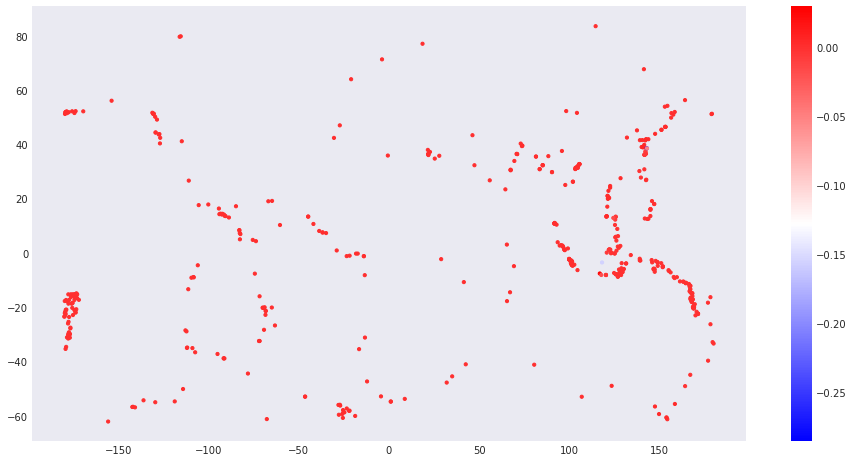

In [452]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

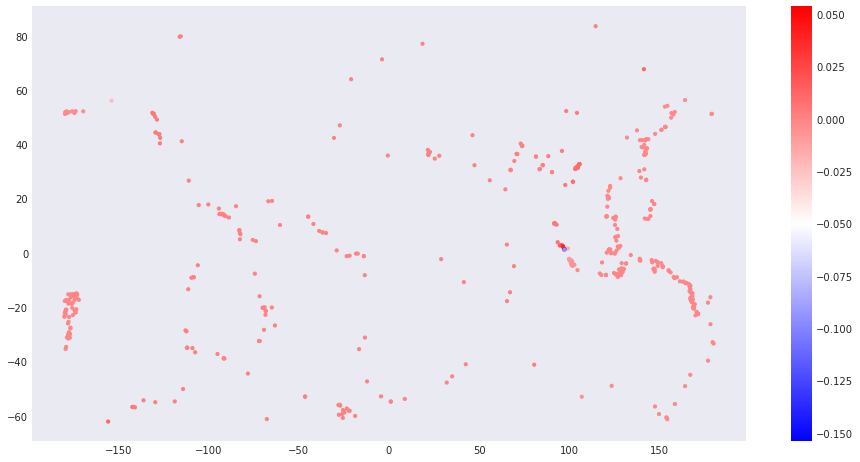

In [453]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

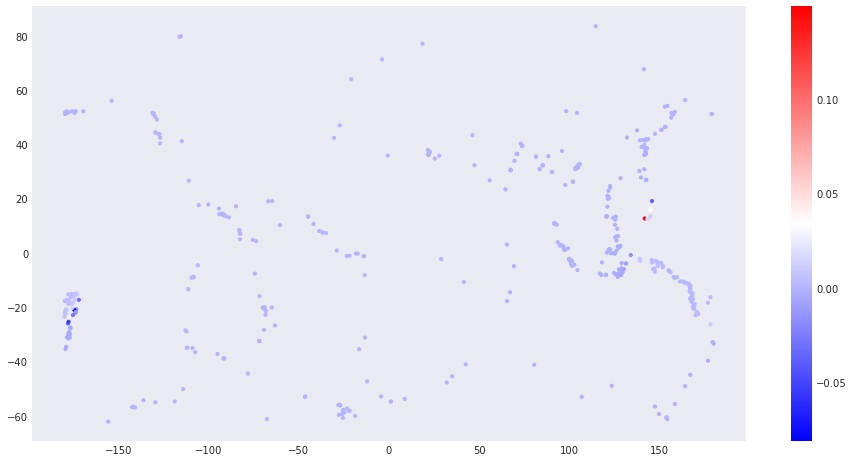

In [454]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

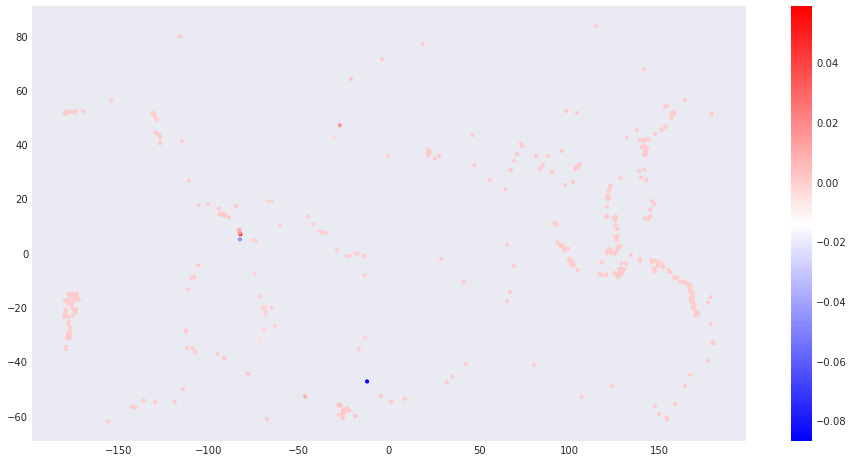

In [455]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

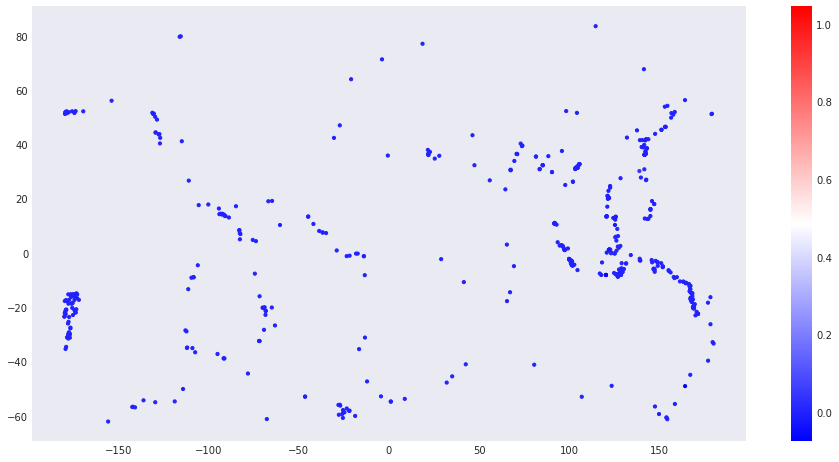

In [456]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

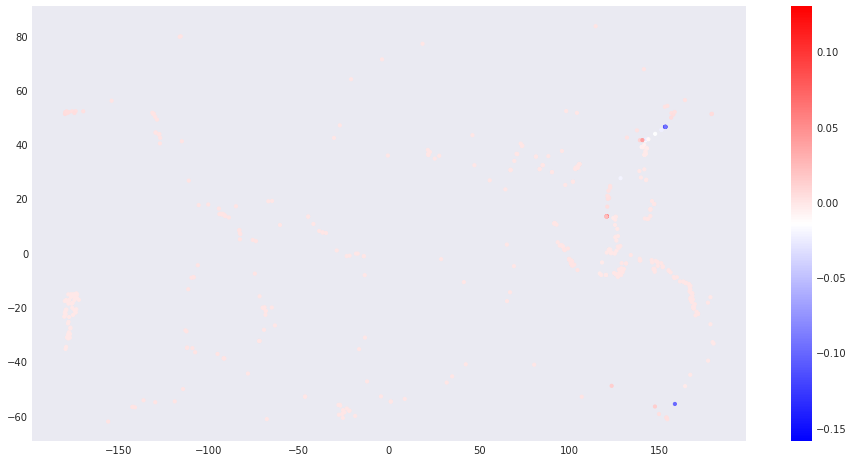

In [457]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2009**, $n=517$

In [458]:
_G6 = nx.Graph(_W[len(_df.query('Year<="2008"')):len(_df.query('Year<="2009"')),len(_df.query('Year<="2008"')):len(_df.query('Year<="2009"'))]-np.identity(len(_df.query('Year=="2009"'))))
_pos6 = nx.spring_layout(_G6,iterations=20)
m_pos6 = list(zip(_df.query('Year=="2009"').Longitude,_df.query('Year=="2009"').Latitude))

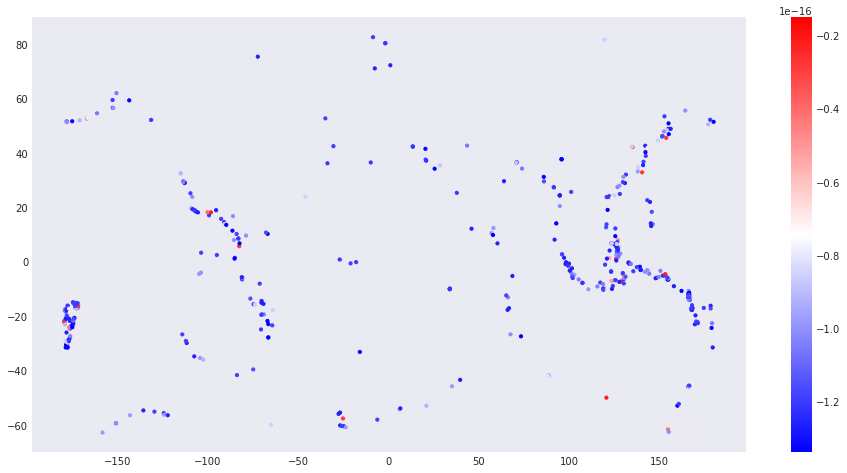

In [459]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

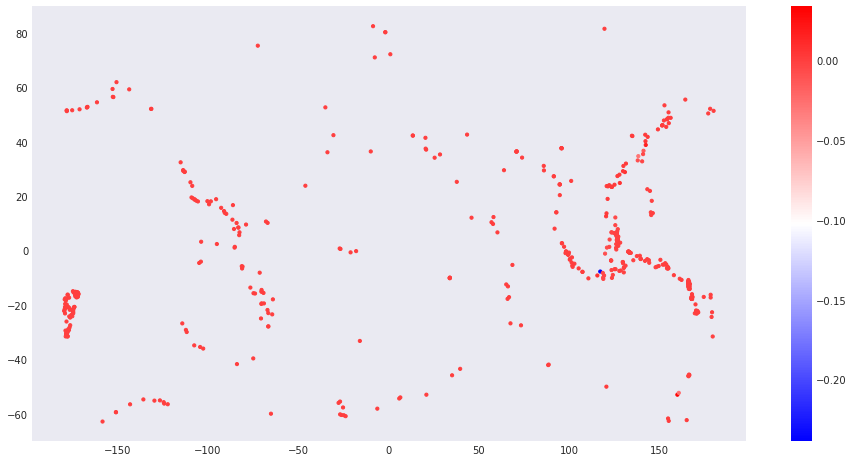

In [460]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

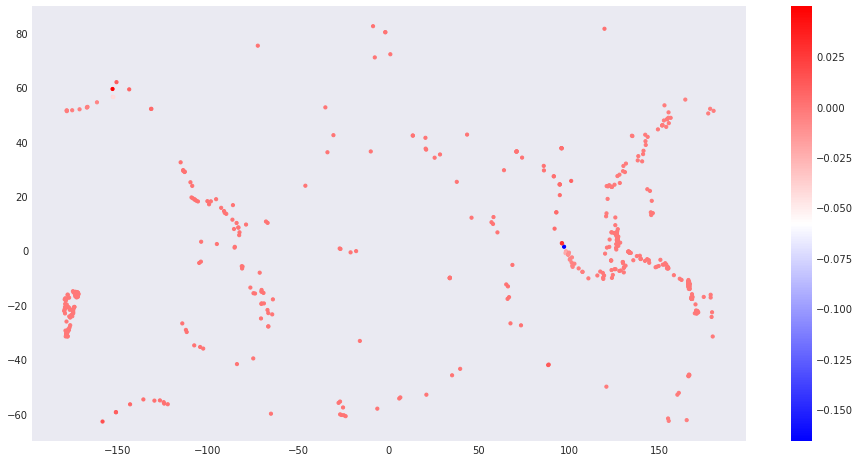

In [461]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

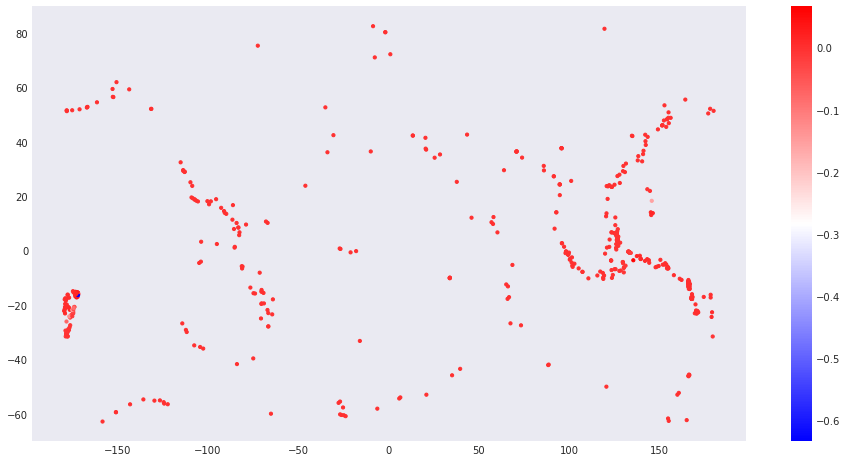

In [462]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

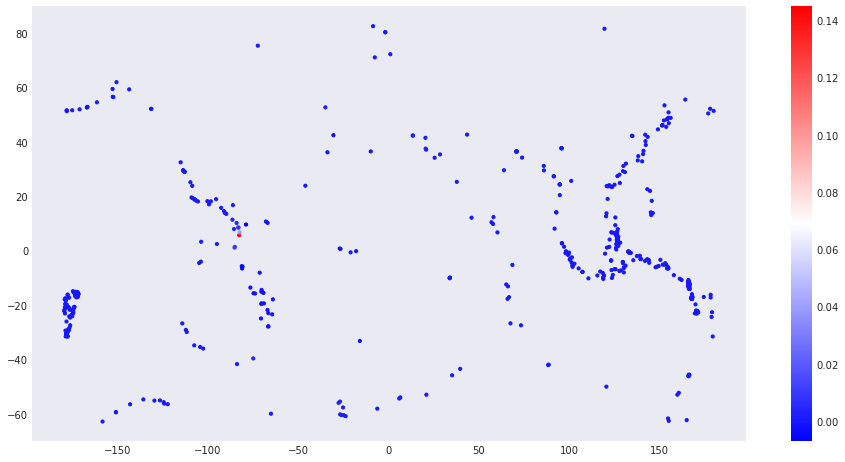

In [463]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

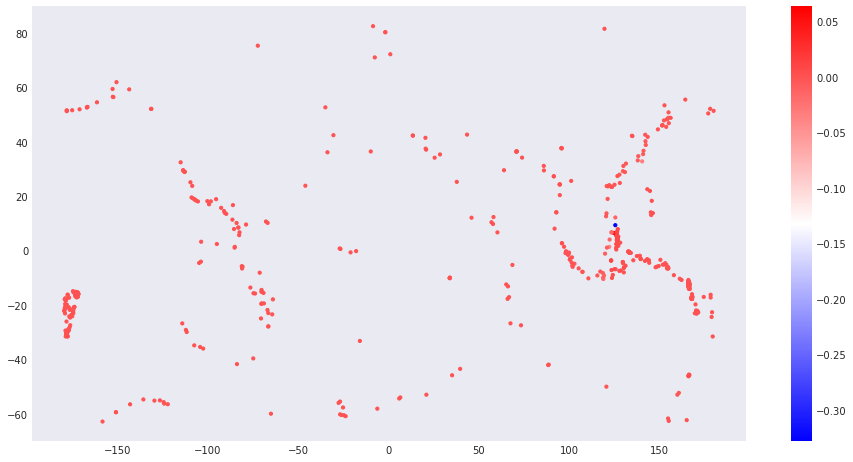

In [464]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

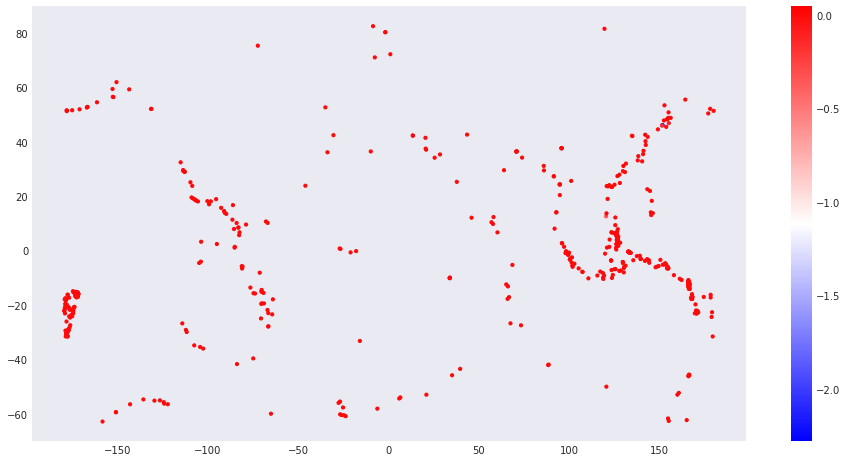

In [465]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2010**, $n=560$

In [466]:
_G7 = nx.Graph(_W[len(_df.query('Year<="2009"')):len(_df.query('Year<="2010"')),len(_df.query('Year<="2009"')):len(_df.query('Year<="2010"'))]-np.identity(len(_df.query('Year=="2010"'))))
_pos7 = nx.spring_layout(_G7,iterations=20)
m_pos7 = list(zip(_df.query('Year=="2010"').Longitude,_df.query('Year=="2010"').Latitude))

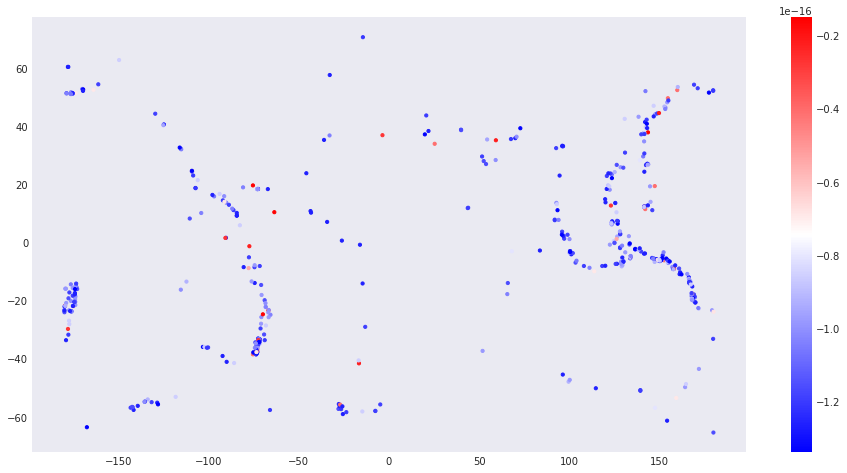

In [467]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

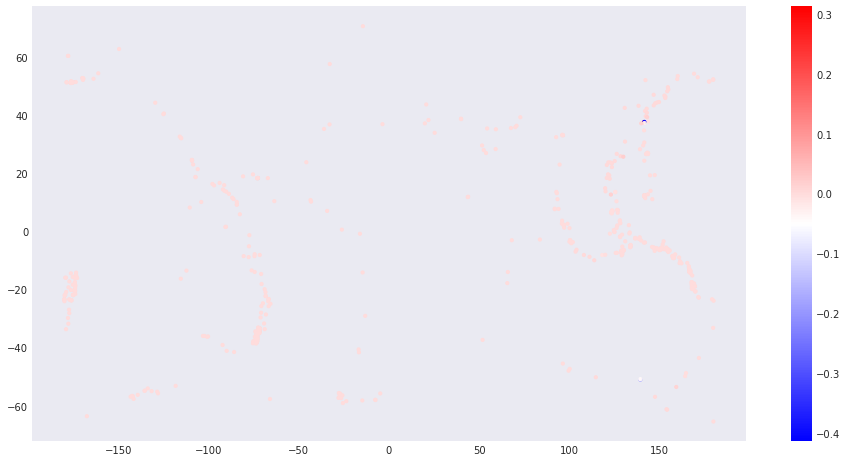

In [468]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

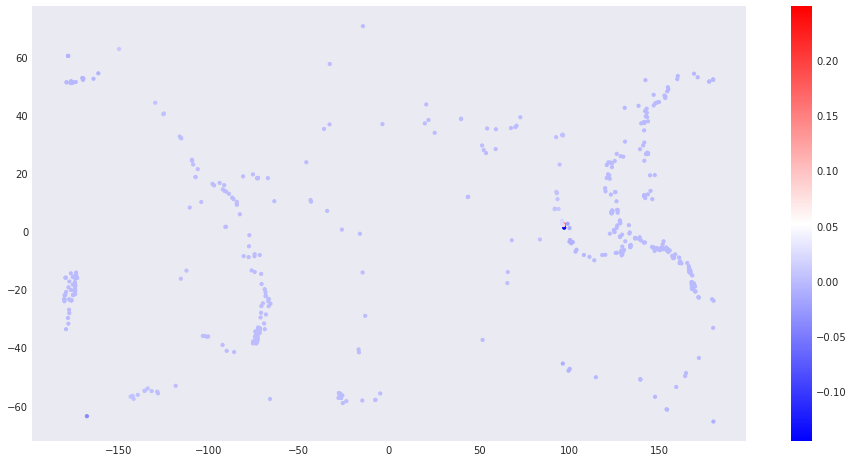

In [469]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

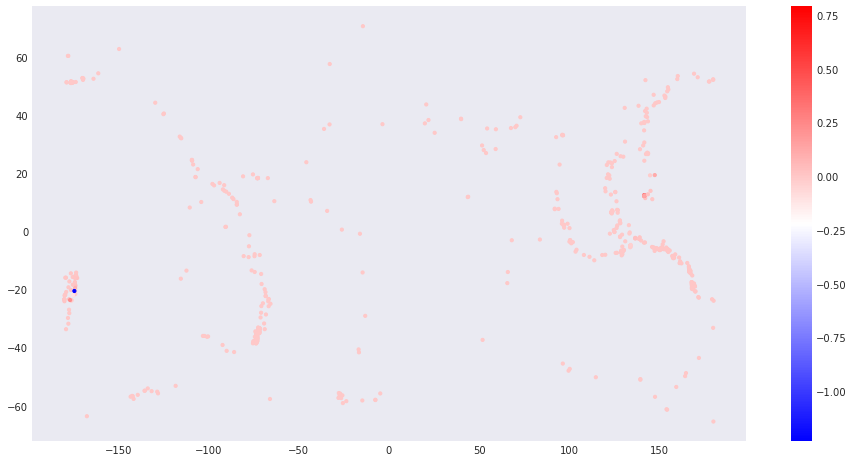

In [470]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

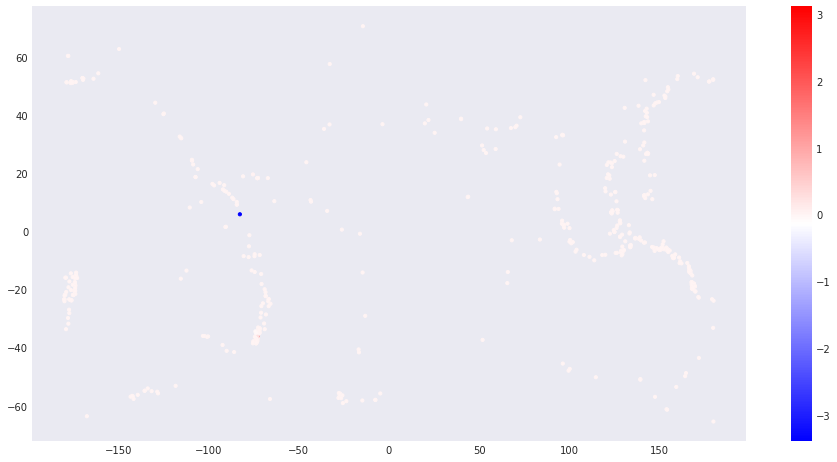

In [471]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

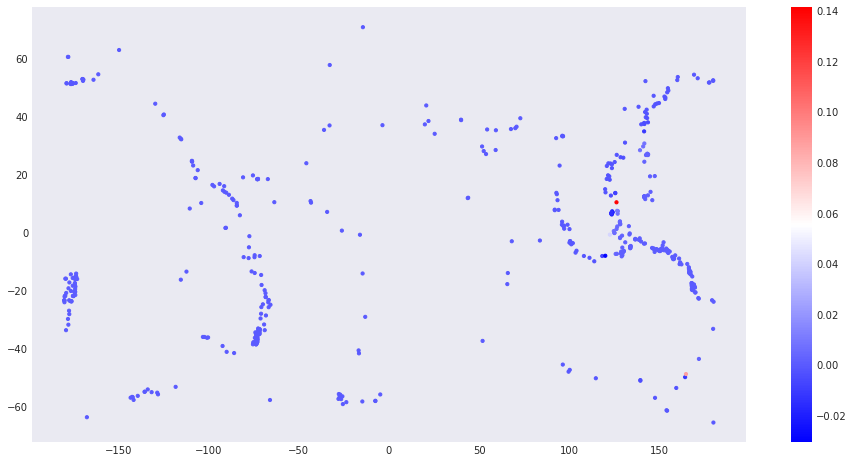

In [472]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

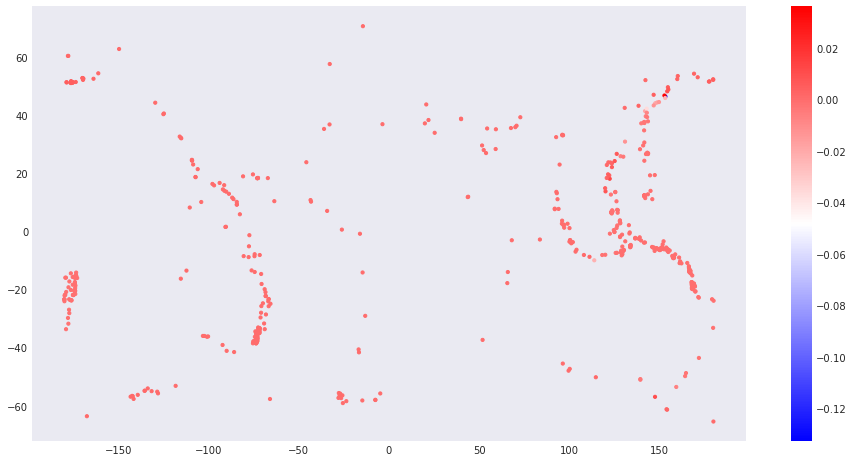

In [473]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2011**, $n=712$

In [474]:
_G8 = nx.Graph(_W[len(_df.query('Year<="2010"')):len(_df.query('Year<="2011"')),len(_df.query('Year<="2010"')):len(_df.query('Year<="2011"'))]-np.identity(len(_df.query('Year=="2011"'))))
_pos8 = nx.spring_layout(_G8,iterations=20)
m_pos8 = list(zip(_df.query('Year=="2011"').Longitude,_df.query('Year=="2011"').Latitude))

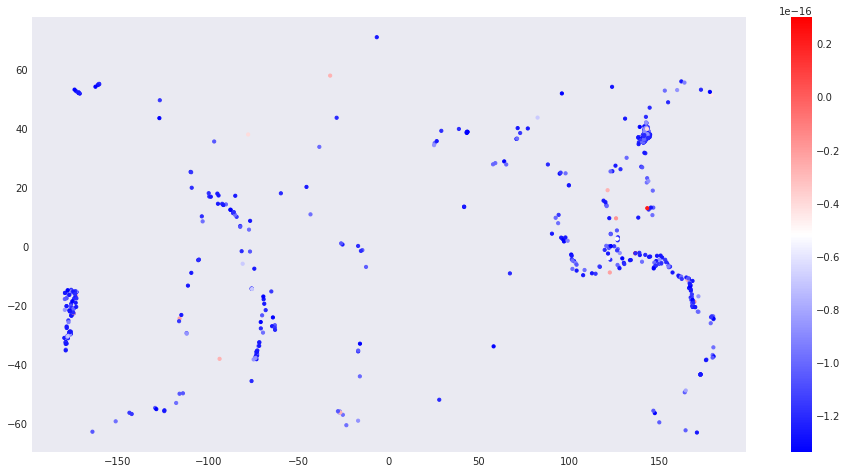

In [475]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

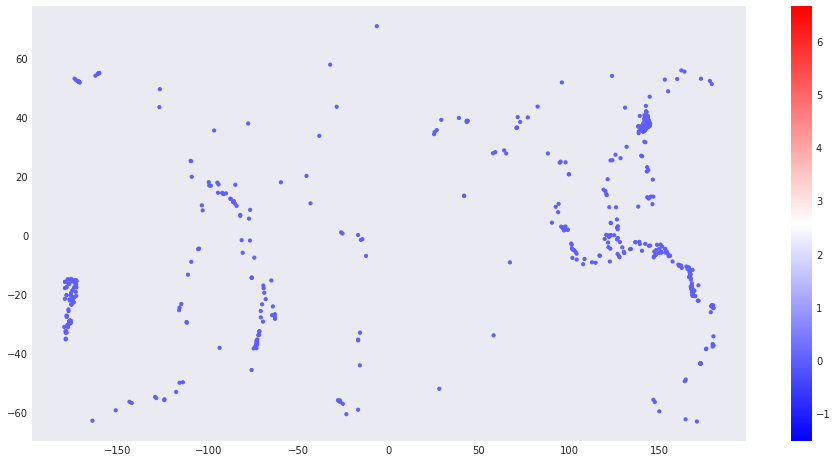

In [476]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

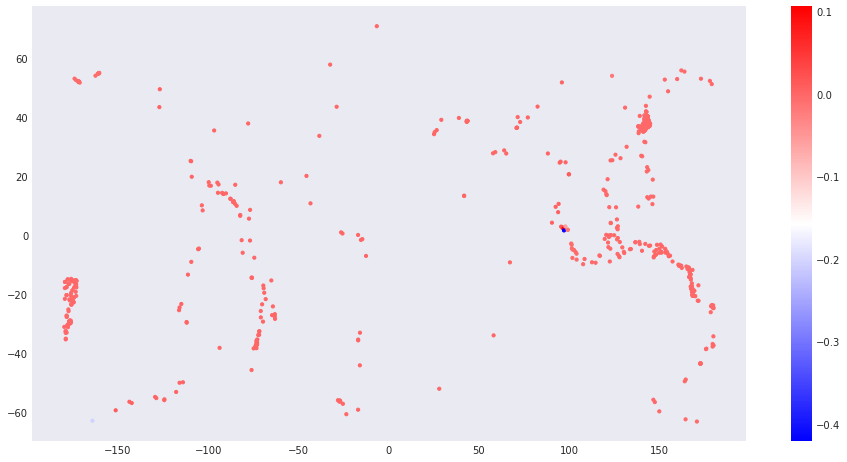

In [477]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

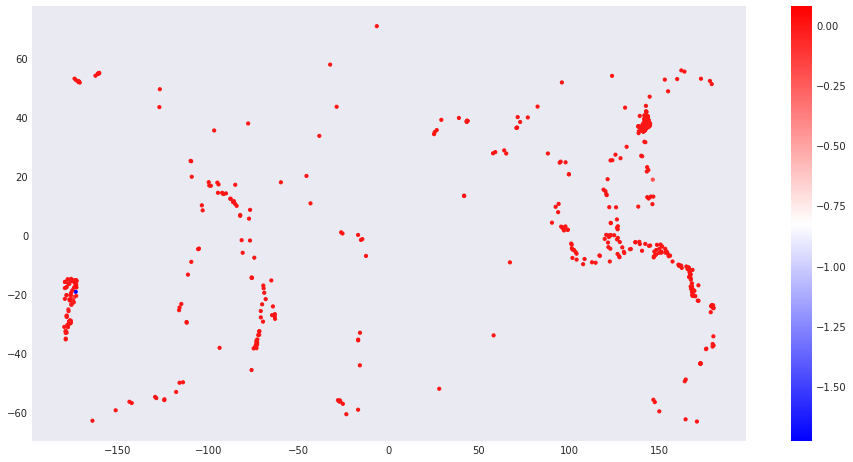

In [478]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

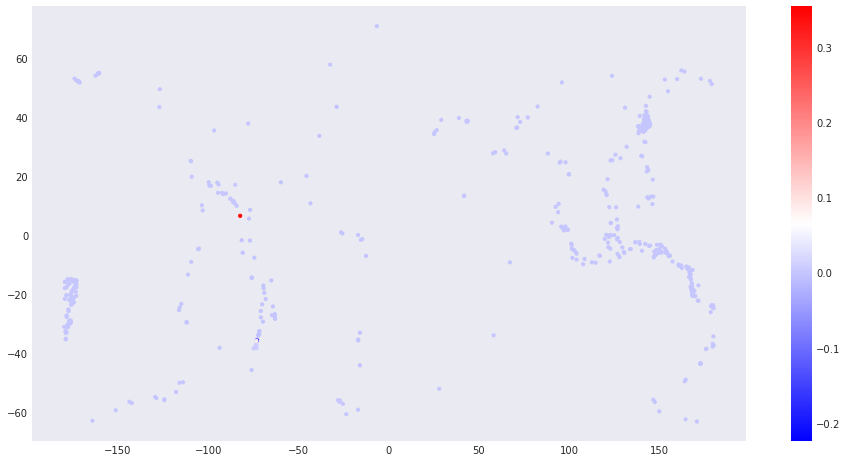

In [479]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

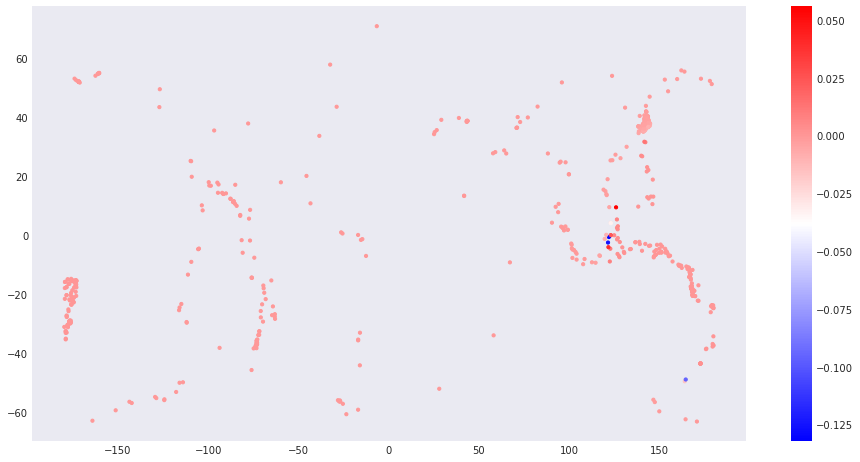

In [480]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

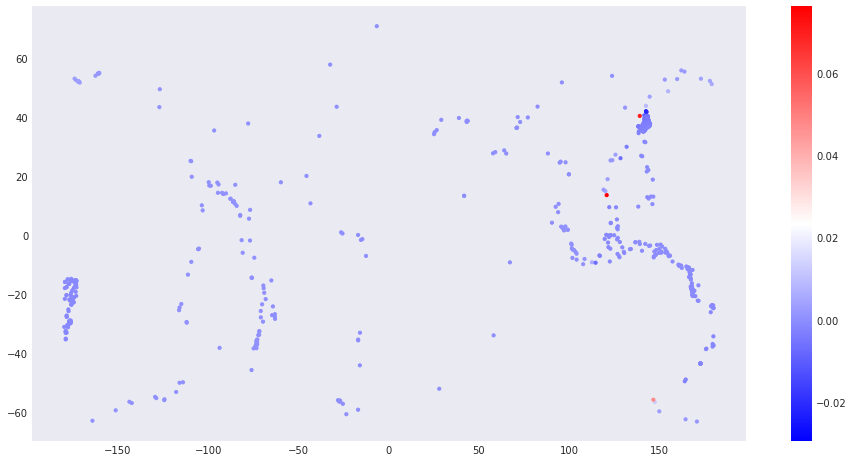

In [481]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()